In [2]:
!pip install torchvision

  Using cached torchvision-0.17.2-cp311-cp311-macosx_10_13_x86_64.whl.metadata (6.6 kB)
Using cached torchvision-0.17.2-cp311-cp311-macosx_10_13_x86_64.whl (1.7 MB)


In [11]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.optim import Adam
from torch import nn
from torch import flatten
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [12]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [13]:
class simple_cnn(nn.Module):
    #Made using LeNet as reference, use relu fn and maxpool
    def __init__(self, classes, numChannels=1):
		# call the parent constructor
        super(simple_cnn, self).__init__()
		# First convolution-relu-maxpool layer
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU()
		# Second convolution-relu-maxpool layer
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU()
		# initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.relu3 = nn.ReLU()
		# initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
		# return the output predictions
        return output

In [54]:
# define training hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 30
# define the train and val splits
TRAIN_SPLIT = 0.75
TEST_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [55]:
print("Loading the FashionMNIST dataset...")
trainData = FashionMNIST(root="data", train=True, download=True,transform=ToTensor())
testData = FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
# calculate the train/validation split
print("Generating the train/Test split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numTestSamples = int(len(trainData) * TEST_SPLIT)
(trainData, testData) = random_split(trainData, [numTrainSamples, numTestSamples], generator=torch.Generator().manual_seed(42))

Loading the FashionMNIST dataset...
Generating the train/Test split...


In [56]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
testDataLoader = DataLoader(testData, batch_size=batch_size)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // batch_size
testSteps = len(testDataLoader.dataset) // batch_size


In [57]:
# initialize the model
print("Initializing the CNN model...")
model = simple_cnn(numChannels=1, classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
}
# measure how long training is going to take
print("Training the network...")
startTime = time.time()


Initializing the CNN model...
Training the network...


In [58]:
# loop over our epochs
for e in range(0, epochs):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	testCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step, and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()


    
    # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in testDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalTestLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
    # calculate the average training and test loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# calculate the training and test accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	testCorrect = testCorrect / len(testDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	H["test_acc"].append(testCorrect)
	# print the model training and testing information
	print("EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Test loss: {:.6f}, Test accuracy: {:.4f}\n".format(avgTestLoss, testCorrect))
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
print("Evaluating network...")
            

EPOCH: 1/30
Train loss: 0.551381, Train accuracy: 0.7963
Test loss: 0.423962, Test accuracy: 0.8492

EPOCH: 2/30
Train loss: 0.352821, Train accuracy: 0.8724
Test loss: 0.324254, Test accuracy: 0.8815

EPOCH: 3/30
Train loss: 0.302423, Train accuracy: 0.8888
Test loss: 0.305911, Test accuracy: 0.8887

EPOCH: 4/30
Train loss: 0.265589, Train accuracy: 0.9022
Test loss: 0.306144, Test accuracy: 0.8915

EPOCH: 5/30
Train loss: 0.242939, Train accuracy: 0.9113
Test loss: 0.278744, Test accuracy: 0.8978

EPOCH: 6/30
Train loss: 0.218734, Train accuracy: 0.9189
Test loss: 0.289127, Test accuracy: 0.8951

EPOCH: 7/30
Train loss: 0.196780, Train accuracy: 0.9276
Test loss: 0.275578, Test accuracy: 0.9043

EPOCH: 8/30
Train loss: 0.181049, Train accuracy: 0.9327
Test loss: 0.268757, Test accuracy: 0.9052

EPOCH: 9/30
Train loss: 0.160805, Train accuracy: 0.9405
Test loss: 0.292648, Test accuracy: 0.8975

EPOCH: 10/30
Train loss: 0.142947, Train accuracy: 0.9467
Test loss: 0.277831, Test accurac

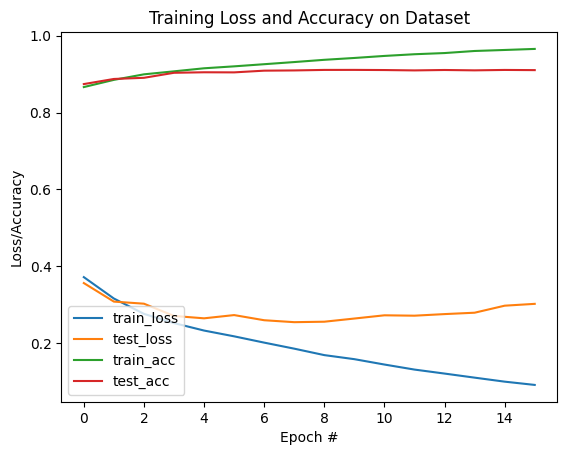

In [10]:
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["test_acc"], label="test_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [25]:
class simple_cnn(nn.Module):
    #Made using LeNet as reference, use relu fn and maxpool
    def __init__(self, classes, numChannels=1):
		# call the parent constructor
        super(simple_cnn, self).__init__()
		# First convolution-relu-maxpool layer
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.relu1 = nn.ReLU()
		# Second convolution-relu-maxpool layer
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.relu2 = nn.ReLU()
		# initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=50, out_features=30)
        self.relu3 = nn.ReLU()
		# initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=30, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
		# return the output predictions
        return output

In [26]:
# define training hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 15
# define the train and val splits
TRAIN_SPLIT = 0.75
TEST_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
print("Loading the FashionMNIST dataset...")
trainData = FashionMNIST(root="data", train=True, download=True,transform=ToTensor())
testData = FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
# calculate the train/validation split
print("Generating the train/Test split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numTestSamples = int(len(trainData) * TEST_SPLIT)
(trainData, testData) = random_split(trainData, [numTrainSamples, numTestSamples], generator=torch.Generator().manual_seed(42))

Loading the FashionMNIST dataset...
Generating the train/Test split...


In [28]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
testDataLoader = DataLoader(testData, batch_size=batch_size)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // batch_size
testSteps = len(testDataLoader.dataset) // batch_size


In [29]:
# initialize the model
print("Initializing the CNN model...")
model = simple_cnn(numChannels=1, classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
}
# measure how long training is going to take
print("Training the network...")
startTime = time.time()


Initializing the CNN model...
Training the network...


In [30]:
# loop over our epochs
for e in range(0, epochs):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	testCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step, and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()


    
    # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in testDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalTestLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
    # calculate the average training and test loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# calculate the training and test accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	testCorrect = testCorrect / len(testDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	H["test_acc"].append(testCorrect)
	# print the model training and testing information
	print("EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Test loss: {:.6f}, Test accuracy: {:.4f}\n".format(avgTestLoss, testCorrect))
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
print("Evaluating network...")
            

EPOCH: 1/15
Train loss: 0.847647, Train accuracy: 0.6987
Test loss: 0.640230, Test accuracy: 0.7653

EPOCH: 2/15
Train loss: 0.569357, Train accuracy: 0.7904
Test loss: 0.540225, Test accuracy: 0.8025

EPOCH: 3/15
Train loss: 0.492999, Train accuracy: 0.8208
Test loss: 0.467430, Test accuracy: 0.8327

EPOCH: 4/15
Train loss: 0.448389, Train accuracy: 0.8394
Test loss: 0.449027, Test accuracy: 0.8368

EPOCH: 5/15
Train loss: 0.415712, Train accuracy: 0.8503
Test loss: 0.435703, Test accuracy: 0.8441

EPOCH: 6/15
Train loss: 0.387596, Train accuracy: 0.8598
Test loss: 0.394768, Test accuracy: 0.8593

EPOCH: 7/15
Train loss: 0.369508, Train accuracy: 0.8698
Test loss: 0.394389, Test accuracy: 0.8555

EPOCH: 8/15
Train loss: 0.353135, Train accuracy: 0.8738
Test loss: 0.379039, Test accuracy: 0.8655

EPOCH: 9/15
Train loss: 0.340438, Train accuracy: 0.8772
Test loss: 0.360631, Test accuracy: 0.8726

EPOCH: 10/15
Train loss: 0.325897, Train accuracy: 0.8830
Test loss: 0.355578, Test accurac

In [37]:
class simple_cnn(nn.Module):
    #Made using LeNet as reference, use relu fn and maxpool
    def __init__(self, classes, numChannels=1):
		# call the parent constructor
        super(simple_cnn, self).__init__()
		# First convolution-relu-maxpool layer
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        self.relu1 = nn.ReLU()
		# Second convolution-relu-maxpool layer
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        self.relu2 = nn.ReLU()
		# initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=450, out_features=300)
        self.relu3 = nn.ReLU()
		# initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=300, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
		# return the output predictions
        return output

In [38]:
# define training hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 15
# define the train and val splits
TRAIN_SPLIT = 0.75
TEST_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
print("Loading the FashionMNIST dataset...")
trainData = FashionMNIST(root="data", train=True, download=True,transform=ToTensor())
testData = FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
# calculate the train/validation split
print("Generating the train/Test split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numTestSamples = int(len(trainData) * TEST_SPLIT)
(trainData, testData) = random_split(trainData, [numTrainSamples, numTestSamples], generator=torch.Generator().manual_seed(42))

Loading the FashionMNIST dataset...
Generating the train/Test split...


In [40]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
testDataLoader = DataLoader(testData, batch_size=batch_size)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // batch_size
testSteps = len(testDataLoader.dataset) // batch_size


In [41]:
# initialize the model
print("Initializing the CNN model...")
model = simple_cnn(numChannels=1, classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
}
# measure how long training is going to take
print("Training the network...")
startTime = time.time()

Initializing the CNN model...
Training the network...


In [42]:
# loop over our epochs
for e in range(0, epochs):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	testCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step, and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()


    
    # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in testDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalTestLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
    # calculate the average training and test loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# calculate the training and test accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	testCorrect = testCorrect / len(testDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	H["test_acc"].append(testCorrect)
	# print the model training and testing information
	print("EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Test loss: {:.6f}, Test accuracy: {:.4f}\n".format(avgTestLoss, testCorrect))
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
print("Evaluating network...")
            

EPOCH: 1/15
Train loss: 0.627884, Train accuracy: 0.7679
Test loss: 0.478579, Test accuracy: 0.8223

EPOCH: 2/15
Train loss: 0.402807, Train accuracy: 0.8533
Test loss: 0.380943, Test accuracy: 0.8574

EPOCH: 3/15
Train loss: 0.335640, Train accuracy: 0.8781
Test loss: 0.361183, Test accuracy: 0.8700

EPOCH: 4/15
Train loss: 0.300141, Train accuracy: 0.8889
Test loss: 0.304590, Test accuracy: 0.8910

EPOCH: 5/15
Train loss: 0.277031, Train accuracy: 0.8975
Test loss: 0.312633, Test accuracy: 0.8877

EPOCH: 6/15
Train loss: 0.260178, Train accuracy: 0.9044
Test loss: 0.302687, Test accuracy: 0.8915

EPOCH: 7/15
Train loss: 0.240405, Train accuracy: 0.9125
Test loss: 0.302730, Test accuracy: 0.8933

EPOCH: 8/15
Train loss: 0.225494, Train accuracy: 0.9160
Test loss: 0.287380, Test accuracy: 0.8979

EPOCH: 9/15
Train loss: 0.211761, Train accuracy: 0.9201
Test loss: 0.288509, Test accuracy: 0.8966

EPOCH: 10/15
Train loss: 0.200301, Train accuracy: 0.9256
Test loss: 0.268196, Test accurac

In [43]:
class simple_cnn(nn.Module):
    #Made using LeNet as reference, use relu fn and maxpool
    def __init__(self, classes, numChannels=1):
		# call the parent constructor
        super(simple_cnn, self).__init__()
		# First convolution-relu-maxpool layer
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU()
		# Second convolution-relu-maxpool layer
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU()
		# initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.relu3 = nn.ReLU()
		# initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
		# return the output predictions
        return output

In [44]:
# define training hyperparameters
learning_rate = 0.005
batch_size = 64
epochs = 15
# define the train and val splits
TRAIN_SPLIT = 0.75
TEST_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [45]:
print("Loading the FashionMNIST dataset...")
trainData = FashionMNIST(root="data", train=True, download=True,transform=ToTensor())
testData = FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
# calculate the train/validation split
print("Generating the train/Test split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numTestSamples = int(len(trainData) * TEST_SPLIT)
(trainData, testData) = random_split(trainData, [numTrainSamples, numTestSamples], generator=torch.Generator().manual_seed(42))

Loading the FashionMNIST dataset...
Generating the train/Test split...


In [46]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
testDataLoader = DataLoader(testData, batch_size=batch_size)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // batch_size
testSteps = len(testDataLoader.dataset) // batch_size


In [47]:
# initialize the model
print("Initializing the CNN model...")
model = simple_cnn(numChannels=1, classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"test_loss": [],
	"test_acc": []
}
# measure how long training is going to take
print("Training the network...")
startTime = time.time()


Initializing the CNN model...
Training the network...


In [48]:
# loop over our epochs
for e in range(0, epochs):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	testCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step, and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()


    
    # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in testDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalTestLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
    # calculate the average training and test loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# calculate the training and test accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	testCorrect = testCorrect / len(testDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	H["test_acc"].append(testCorrect)
	# print the model training and testing information
	print("EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Test loss: {:.6f}, Test accuracy: {:.4f}\n".format(avgTestLoss, testCorrect))
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
print("Evaluating network...")
            

EPOCH: 1/15
Train loss: 0.492459, Train accuracy: 0.8176
Test loss: 0.383255, Test accuracy: 0.8560

EPOCH: 2/15
Train loss: 0.336578, Train accuracy: 0.8762
Test loss: 0.333642, Test accuracy: 0.8787

EPOCH: 3/15
Train loss: 0.297253, Train accuracy: 0.8888
Test loss: 0.315530, Test accuracy: 0.8851

EPOCH: 4/15
Train loss: 0.276096, Train accuracy: 0.8958
Test loss: 0.314185, Test accuracy: 0.8819

EPOCH: 5/15
Train loss: 0.253825, Train accuracy: 0.9051
Test loss: 0.314903, Test accuracy: 0.8925

EPOCH: 6/15
Train loss: 0.242140, Train accuracy: 0.9079
Test loss: 0.322481, Test accuracy: 0.8877

EPOCH: 7/15
Train loss: 0.226560, Train accuracy: 0.9128
Test loss: 0.333544, Test accuracy: 0.8837

EPOCH: 8/15
Train loss: 0.218671, Train accuracy: 0.9173
Test loss: 0.337382, Test accuracy: 0.8895

EPOCH: 9/15
Train loss: 0.204436, Train accuracy: 0.9234
Test loss: 0.354967, Test accuracy: 0.8938

EPOCH: 10/15
Train loss: 0.192274, Train accuracy: 0.9274
Test loss: 0.346163, Test accurac